# TS5:Filtrado digital lineal de ECG

### Francisco Mato y Angel Joseph Vargas Martinez

## Desarrollo

In [1]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
from scipy.io.wavfile import write
import sounddevice as sd



mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
fs=1000
cant_muestras=ecg_one_lead.shape[0]
#############
# Plantilla #
#############

nyq_frec = fs/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = 0.1 # Hz
wp1 = 0.8 # Hz
wp2 = 30 # Hz
ws2 = 30.7 # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0,         ws1,         wp1,     wp2,     ws2,         fs/2  ]) 
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)


gains[5]=0 


la plantilla se penso a partir de hacer el periodograma a partir de welch de la ecg sin ruido el caul no ayuda a ver que el ancho de banda de la ecg es de 0 a 30hz.
el primer filtro en hacerse es un filtro IR con aproximacion de maxima planicida o butterworth

C:\Users\franc\AppData\Local\Temp\ipykernel_22000\1406672176.py:25: RuntimeWarning: divide by zero encountered in log10
  modulo = 20 * np.log10(np.abs(h))
C:\Users\franc\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_filter_design.py:1230: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


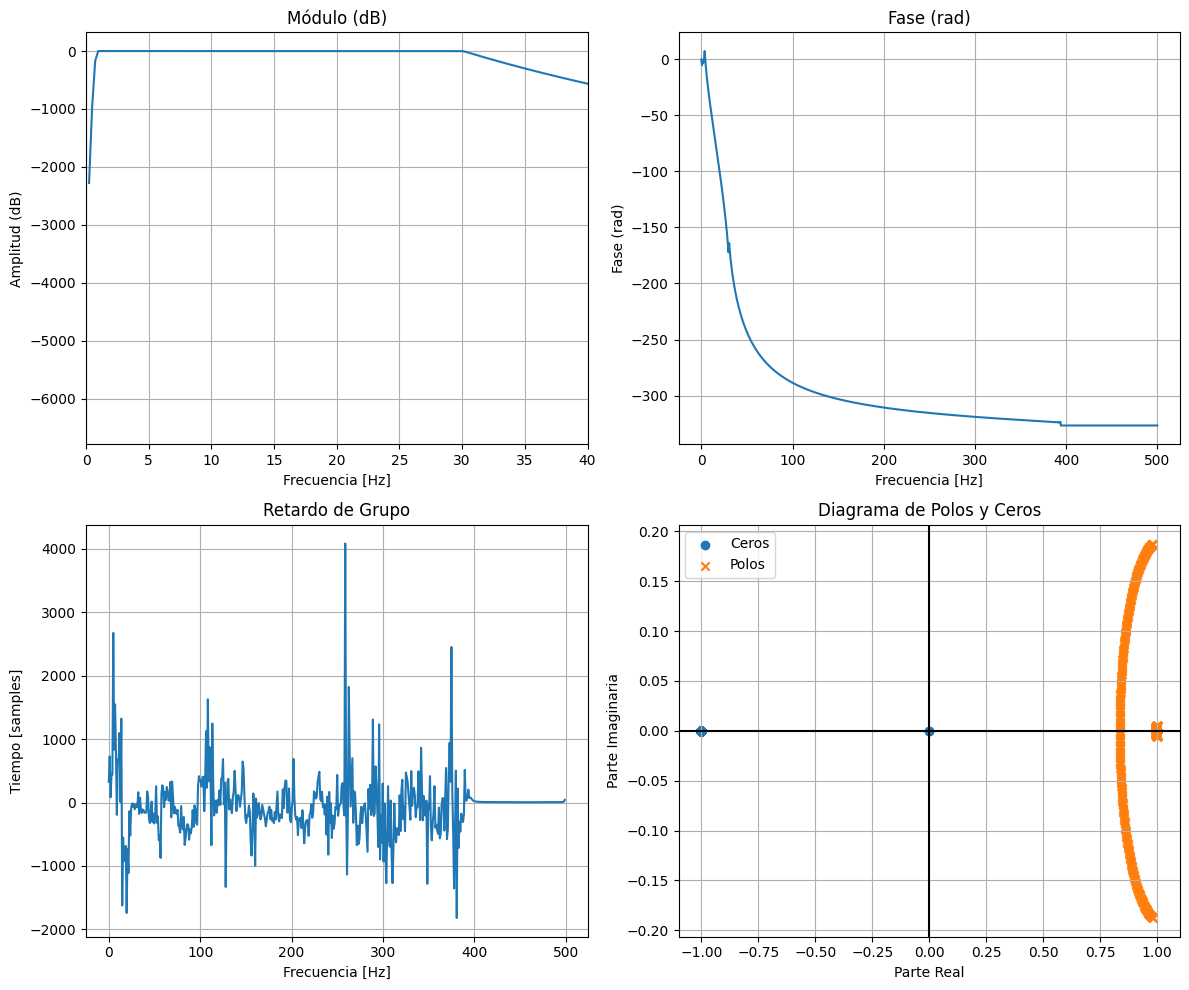

In [2]:
####################
# Diseño del filtro#
####################


f_aprox = "butter"
mi_sos_butt=signal.iirdesign(wp=[wp1,wp2],
                              ws=[ws1,ws2],
                              gpass=ripple,
                              gstop=atenuacion,
                              analog=False,
                              ftype = f_aprox,
                              output= "sos",fs=fs)

ECG_f_win=signal.sosfilt(mi_sos_butt , ecg_one_lead)


##########################
# respuesta en frecuencia#
##########################

w, h = signal.sosfreqz(mi_sos_butt , worN=2048, fs=fs)

# Módulo en dB
modulo = 20 * np.log10(np.abs(h))

# Fase en radianes
fase = np.unwrap(np.angle(h))


# ---------------------------------------------------
# 3. RETARDO DE GRUPO
# ---------------------------------------------------

w_gd, gd = signal.group_delay((signal.sos2tf(mi_sos_butt )), fs=fs)


# ---------------------------------------------------
# 4. DIAGRAMA DE POLOS Y CEROS
# ---------------------------------------------------

z, p, k = signal.sos2zpk(mi_sos_butt)

plt.figure(figsize=(12,10))

# --- Magnitud ---
plt.subplot(2,2,1)
plt.plot(w, modulo)
plt.title("Módulo (dB)")
plt.ylabel("Amplitud (dB)")
plt.xlabel("Frecuencia [Hz]")
plt.xlim(0,40)
plt.grid()

# --- Fase ---
plt.subplot(2,2,2)
plt.plot(w, fase)
plt.title("Fase (rad)")
plt.ylabel("Fase (rad)")
plt.xlabel("Frecuencia [Hz]")
plt.grid()

# --- Retardo de grupo ---
plt.subplot(2,2,3)
plt.plot(w_gd, gd)
plt.title("Retardo de Grupo")
plt.ylabel("Tiempo [samples]")
plt.xlabel("Frecuencia [Hz]")
plt.grid()

# --- Polos y ceros ---
plt.subplot(2,2,4)
plt.scatter(np.real(z), np.imag(z), marker='o', label="Ceros")
plt.scatter(np.real(p), np.imag(p), marker='x', label="Polos")
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title("Diagrama de Polos y Ceros")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

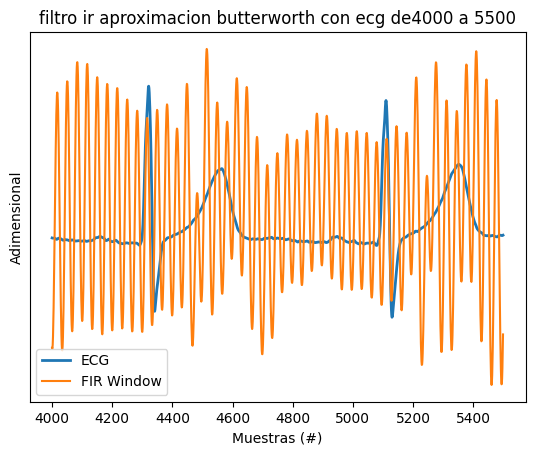

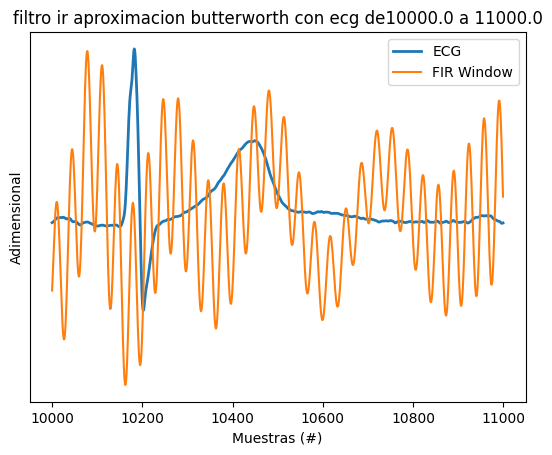

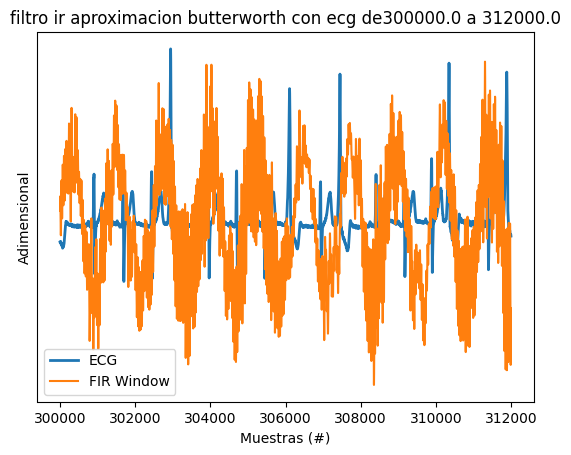

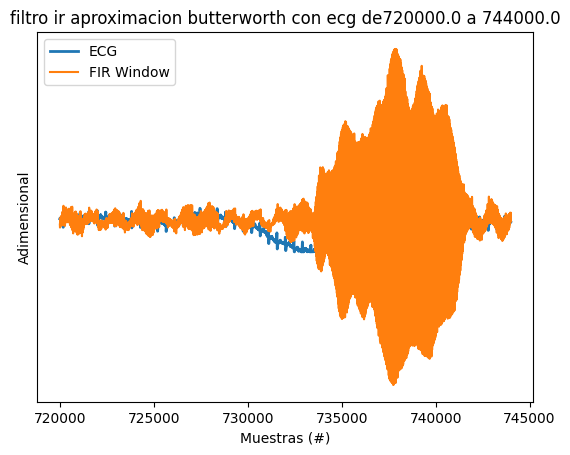

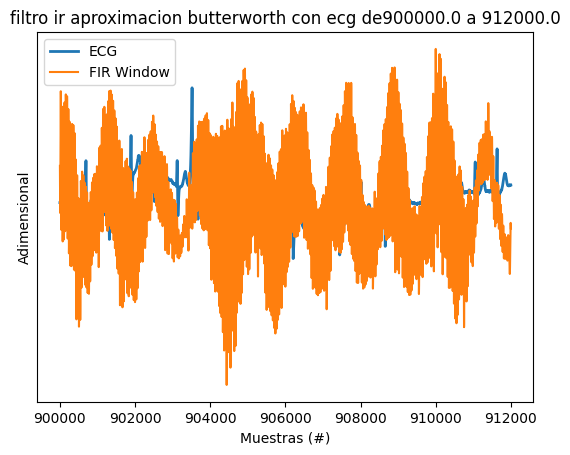

In [3]:
###################################
# Regiones de interés sin ruido #
###################################

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region ], label='FIR Window')
   
    plt.title('filtro ir aproximacion butterworth con ecg de' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés con ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ECG_f_win[zoom_region ], label='FIR Window')
   
    plt.title('filtro ir aproximacion butterworth con ecg de' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

el siguiete filtro en diseñarse es otro IR con aproximaxion via cauer 

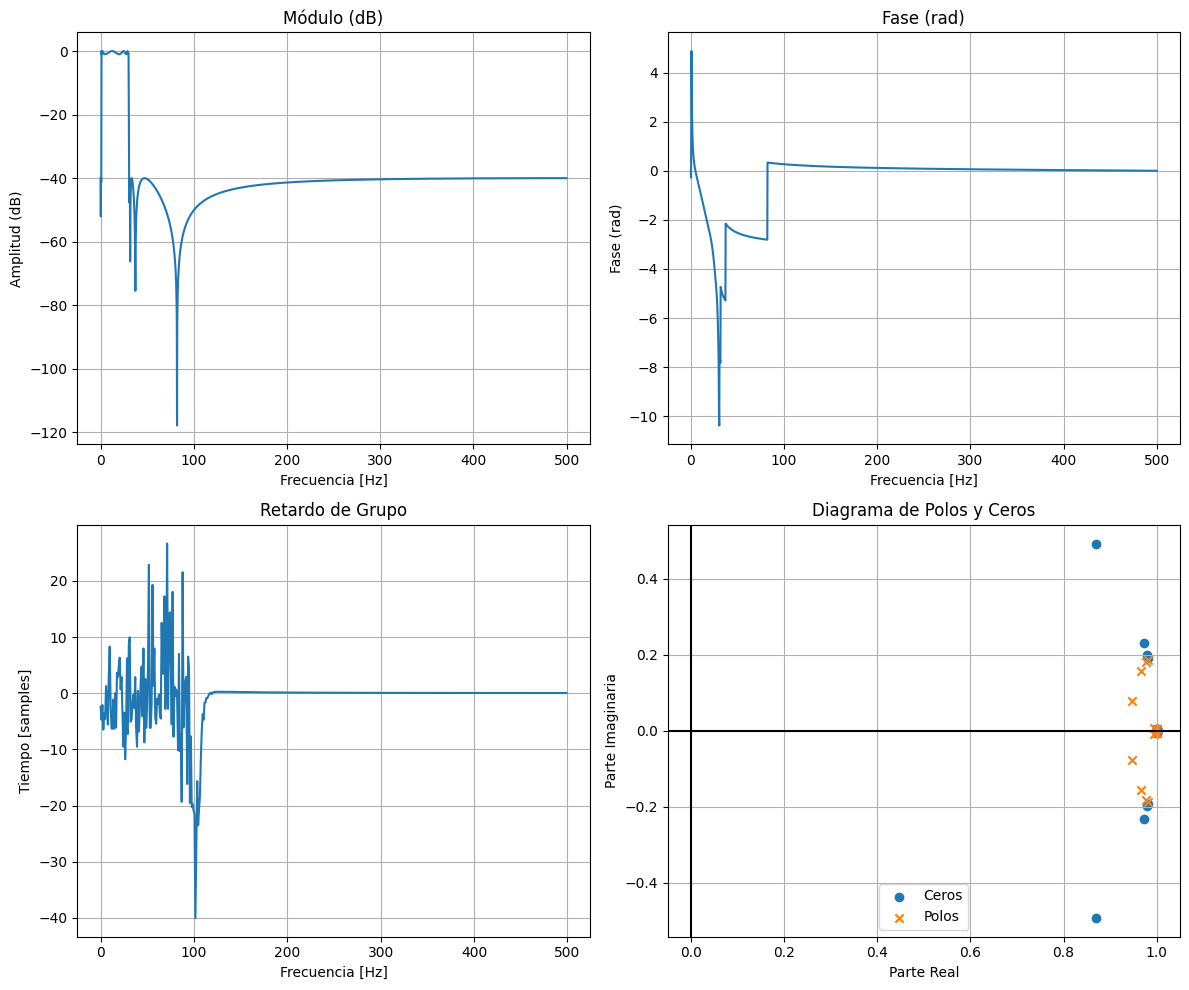

In [4]:
####################
# Diseño del filtro#
####################


f_aprox = "cauer"
mi_sos_cauer=signal.iirdesign(wp=[wp1,wp2],
                              ws=[ws1,ws2],
                              gpass=ripple,
                              gstop=atenuacion,
                              analog=False,
                              ftype = f_aprox,
                              output= "sos",fs=fs)

ECG_f_win=signal.sosfilt(mi_sos_cauer , ecg_one_lead)


##########################
# respuesta en frecuencia#
##########################

w, h = signal.sosfreqz(mi_sos_cauer , worN=2048, fs=fs)

# Módulo en dB
modulo = 20 * np.log10(np.abs(h))

# Fase en radianes
fase = np.unwrap(np.angle(h))


# ---------------------------------------------------
# 3. RETARDO DE GRUPO
# ---------------------------------------------------

w_gd, gd = signal.group_delay((signal.sos2tf(mi_sos_cauer )), fs=fs)


# ---------------------------------------------------
# 4. DIAGRAMA DE POLOS Y CEROS
# ---------------------------------------------------

z, p, k = signal.sos2zpk(mi_sos_cauer)

plt.figure(figsize=(12,10))

# --- Magnitud ---
plt.subplot(2,2,1)
plt.plot(w, modulo)
plt.title("Módulo (dB)")
plt.ylabel("Amplitud (dB)")
plt.xlabel("Frecuencia [Hz]")
plt.grid()

# --- Fase ---
plt.subplot(2,2,2)
plt.plot(w, fase)
plt.title("Fase (rad)")
plt.ylabel("Fase (rad)")
plt.xlabel("Frecuencia [Hz]")
plt.grid()

# --- Retardo de grupo ---
plt.subplot(2,2,3)
plt.plot(w_gd, gd)
plt.title("Retardo de Grupo")
plt.ylabel("Tiempo [samples]")
plt.xlabel("Frecuencia [Hz]")
plt.grid()

# --- Polos y ceros ---
plt.subplot(2,2,4)
plt.scatter(np.real(z), np.imag(z), marker='o', label="Ceros")
plt.scatter(np.real(p), np.imag(p), marker='x', label="Polos")
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.title("Diagrama de Polos y Ceros")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

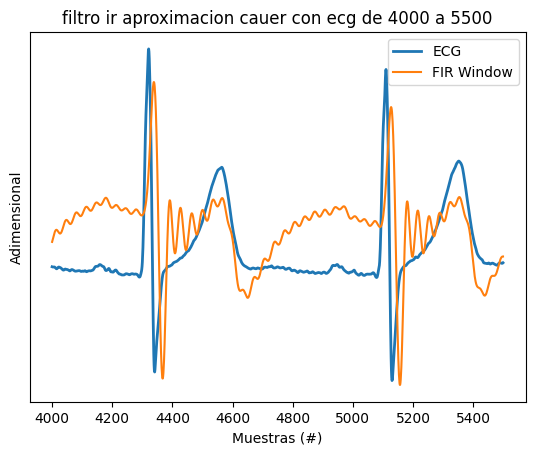

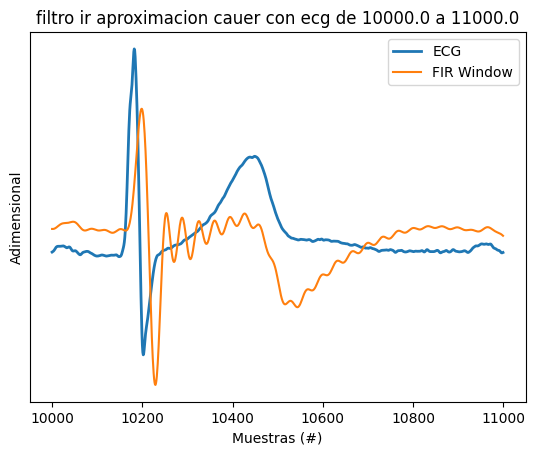

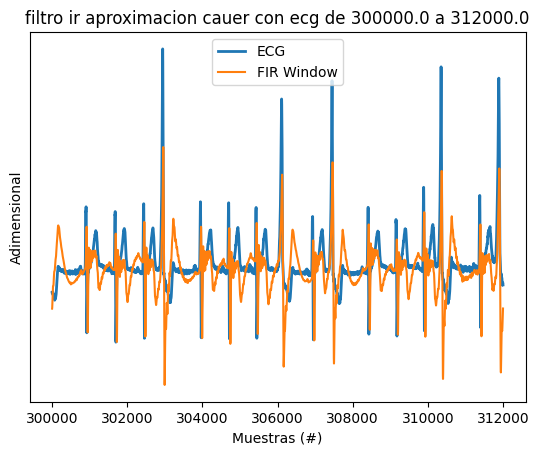

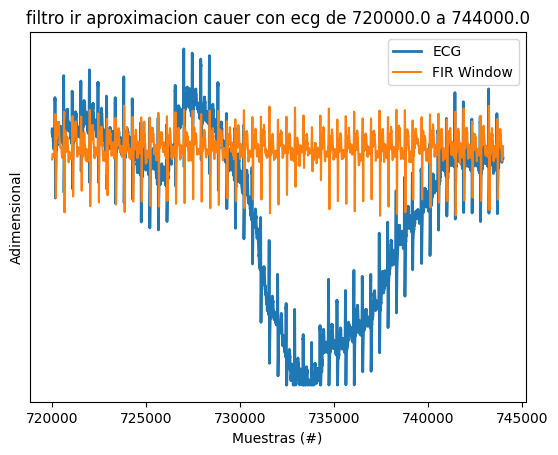

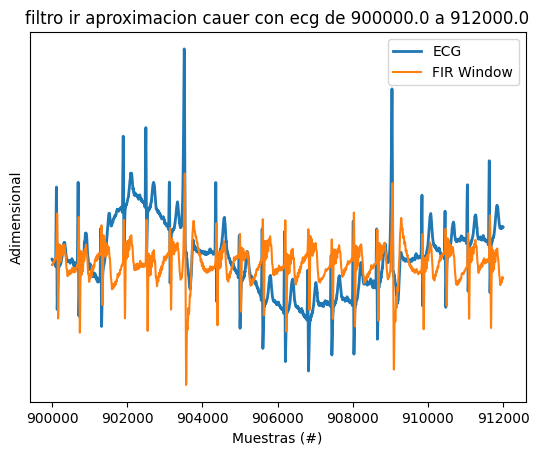

In [5]:
###################################
# Regiones de interés con ruido #
###################################

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region ], label='FIR Window')
   
    plt.title('filtro ir aproximacion cauer con ecg de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés sin ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ECG_f_win[zoom_region ], label='FIR Window')
   
    plt.title('filtro ir aproximacion cauer con ecg de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

ahora seguimos con los filtros FIR a partir de ventaneo, siendo el primero a partir de una ventana tipo hamming

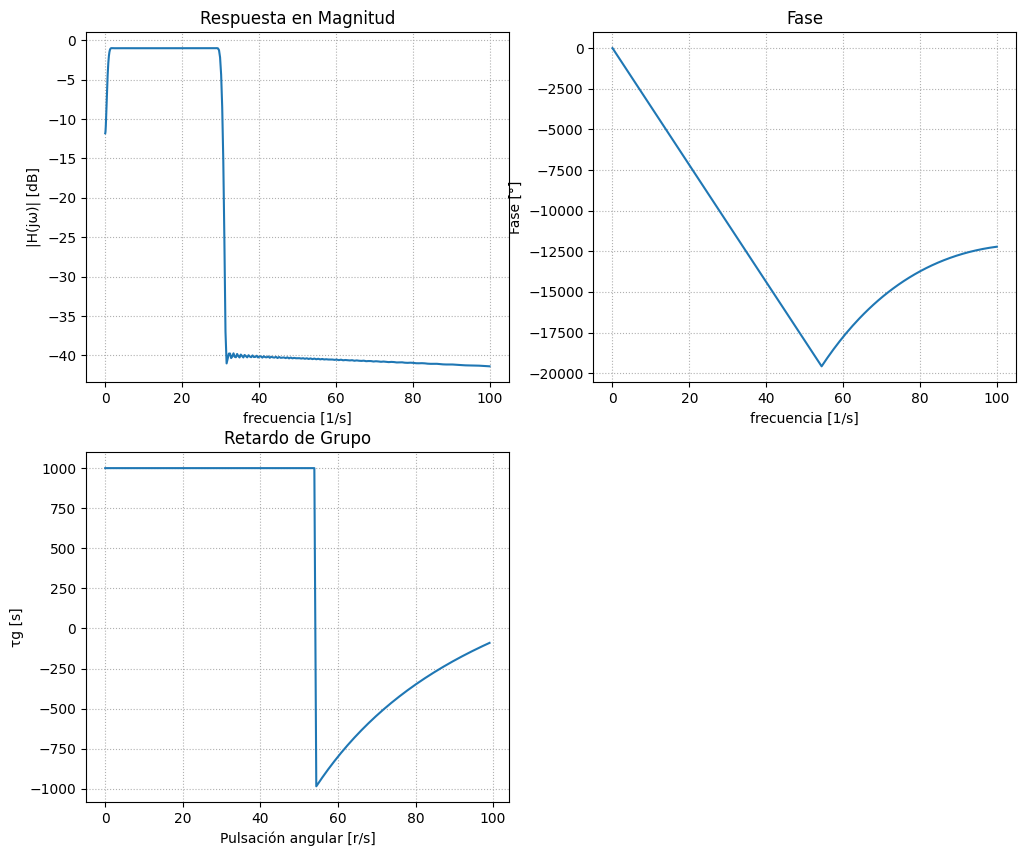

In [6]:
####################
# Diseño del filtro#
####################

cant_coef = 2000
demora = (cant_coef -1)

fir_win_rec=sig.firwin2(numtaps=cant_coef,freq=frecs,gain=gains,fs=fs,window="hamming")


ECG_f_win = sig.lfilter(b=fir_win_rec, a=1, x=ecg_one_lead)

##########################
# respuesta en frecuencia#
##########################

w , h= sig.freqz(b= fir_win_rec,worN=np.logspace(-2,2,1000),fs=fs)

phase = np.unwrap(np.angle(h))
# Retardo de grupo = -dφ/dω
w_rad=w/(fs/2) *np.pi

gd = -np.diff(phase) / np.diff(w_rad)

# --- Polos y ceros ---
# z, p, k = signal.fir2zpk(sig.tf2sos(b=fir_win_hamming,a=1))


plt.figure(figsize=(12,10))

# Magnitud
plt.subplot(2,2,1)
plt.plot(w, 20*np.log10(abs(h)))
plt.title('Respuesta en Magnitud')
plt.xlabel('frecuencia [1/s]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')

# Fase
plt.subplot(2,2,2)
plt.plot(w, np.degrees(phase))
plt.title('Fase')
plt.xlabel('frecuencia [1/s]')
plt.ylabel('Fase [°]')
plt.grid(True, which='both', ls=':')

# Retardo de grupo
plt.subplot(2,2,3)
plt.plot(w[:-1], gd)
plt.title('Retardo de Grupo')
plt.xlabel('Pulsación angular [r/s]')
plt.ylabel('τg [s]')
plt.grid(True, which='both', ls=':')

# Diagrama de polos y ceros
# plt.subplot(2,2,4)
# plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Polos')
# if len(z) > 0:
#                    plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Ceros')
# plt.axhline(0, color='k', lw=0.5)
# plt.axvline(0, color='k', lw=0.5)
# plt.title('Diagrama de Polos y Ceros (plano s)')
# plt.xlabel('σ [rad/s]')
# plt.ylabel('jω [rad/s]')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

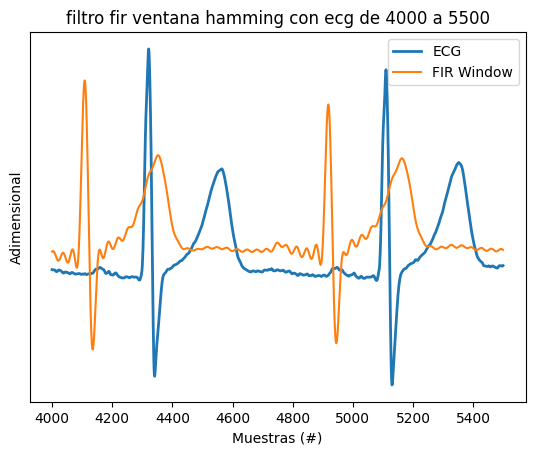

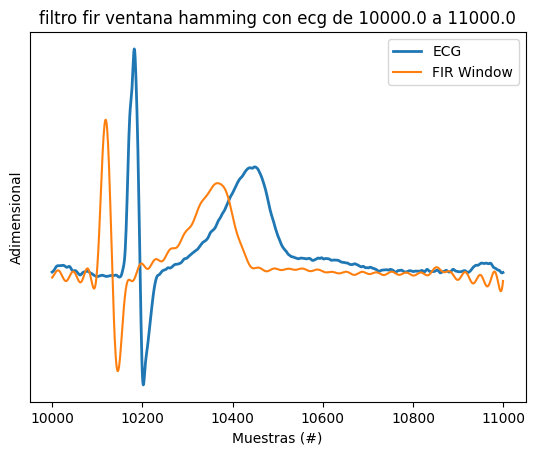

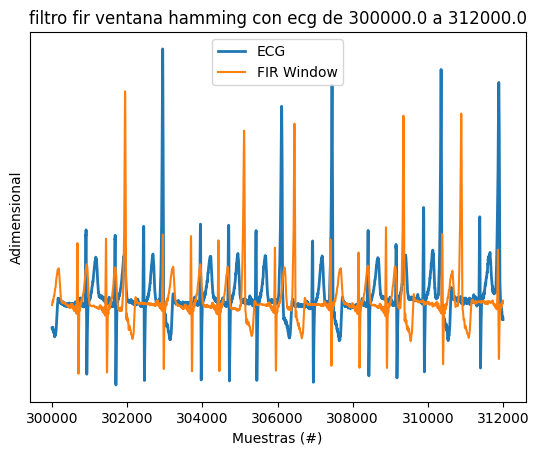

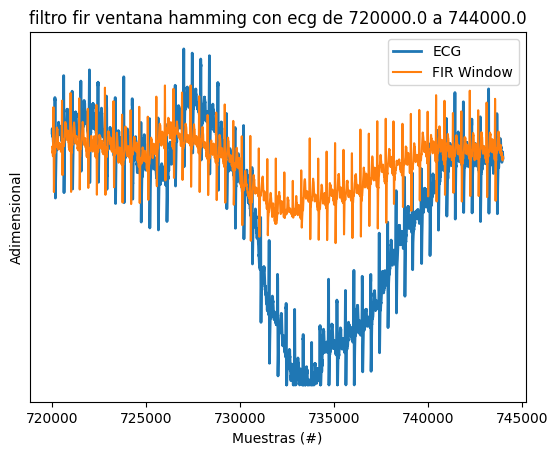

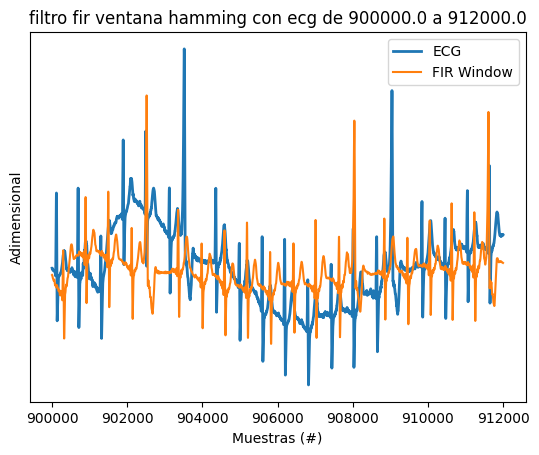

In [7]:
###################################
# Regiones de interés sin ruido #
###################################

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('filtro fir ventana hamming con ecg de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés con ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('filtro fir ventana hamming con ecg de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

el siguiente filtro es tambien un FIR a partir de ventaneo pero este es apartir de una ventana tipo cuadrada

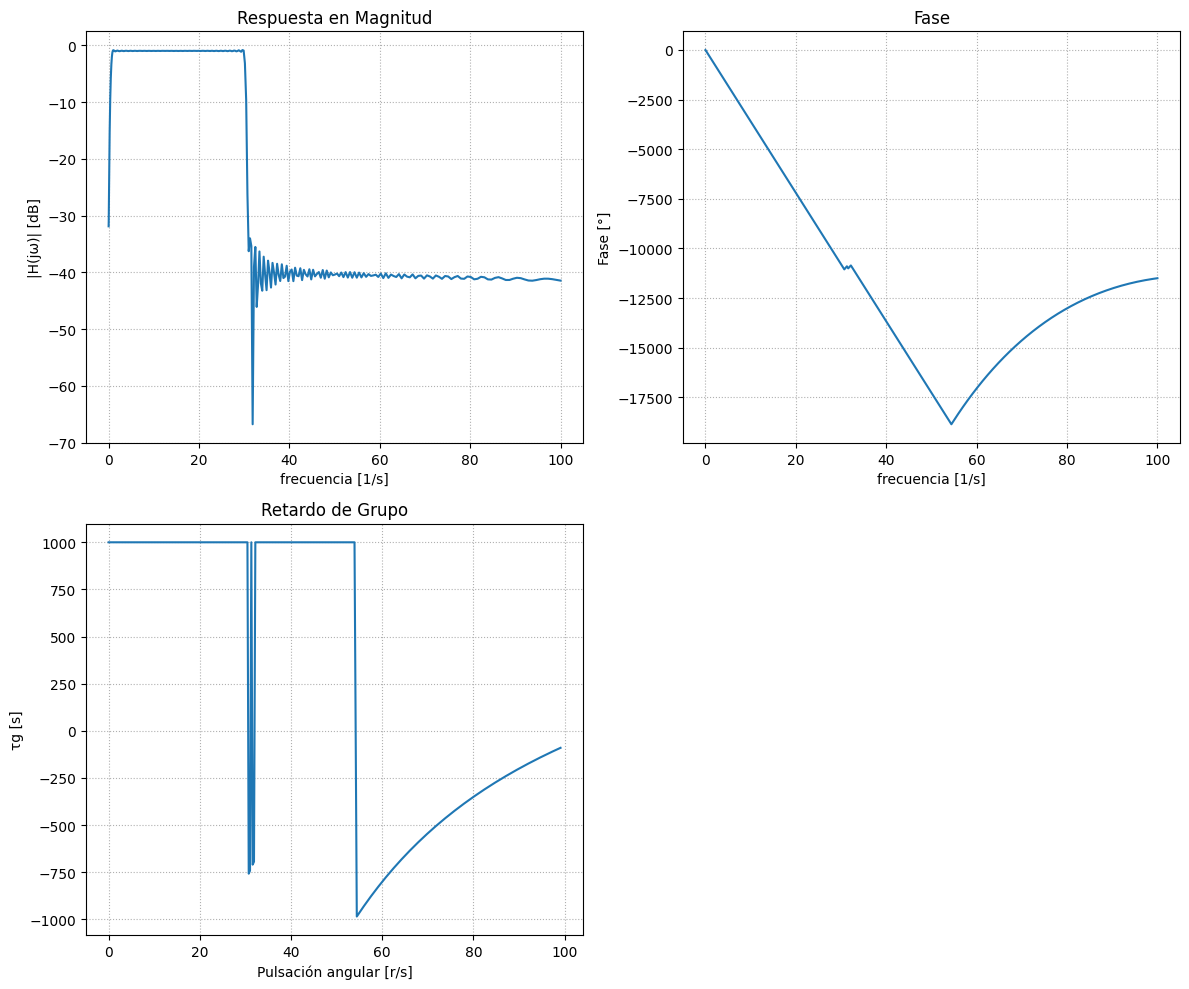

In [8]:
####################
# Diseño del filtro#
####################

cant_coef = 2000
demora = (cant_coef -1)

fir_win_rec=sig.firwin2(numtaps=cant_coef,freq=frecs,gain=gains,fs=fs,window="boxcar")


ECG_f_win = sig.lfilter(b=fir_win_rec, a=1, x=ecg_one_lead)

##########################
# respuesta en frecuencia#
##########################

w , h= sig.freqz(b= fir_win_rec,worN=np.logspace(-2,2,1000),fs=fs)

phase = np.unwrap(np.angle(h))
# Retardo de grupo = -dφ/dω
w_rad=w/(fs/2) *np.pi

gd = -np.diff(phase) / np.diff(w_rad)

# --- Polos y ceros ---
# z, p, k = signal.fir2zpk(sig.tf2sos(b=fir_win_hamming,a=1))


plt.figure(figsize=(12,10))

# Magnitud
plt.subplot(2,2,1)
plt.plot(w, 20*np.log10(abs(h)))
plt.title('Respuesta en Magnitud')
plt.xlabel('frecuencia [1/s]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')

# Fase
plt.subplot(2,2,2)
plt.plot(w, np.degrees(phase))
plt.title('Fase')
plt.xlabel('frecuencia [1/s]')
plt.ylabel('Fase [°]')
plt.grid(True, which='both', ls=':')

# Retardo de grupo
plt.subplot(2,2,3)
plt.plot(w[:-1], gd)
plt.title('Retardo de Grupo')
plt.xlabel('Pulsación angular [r/s]')
plt.ylabel('τg [s]')
plt.grid(True, which='both', ls=':')

# Diagrama de polos y ceros
# plt.subplot(2,2,4)
# plt.plot(np.real(p), np.imag(p), 'x', markersize=10, label='Polos')
# if len(z) > 0:
#                    plt.plot(np.real(z), np.imag(z), 'o', markersize=10, fillstyle='none', label='Ceros')
# plt.axhline(0, color='k', lw=0.5)
# plt.axvline(0, color='k', lw=0.5)
# plt.title('Diagrama de Polos y Ceros (plano s)')
# plt.xlabel('σ [rad/s]')
# plt.ylabel('jω [rad/s]')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

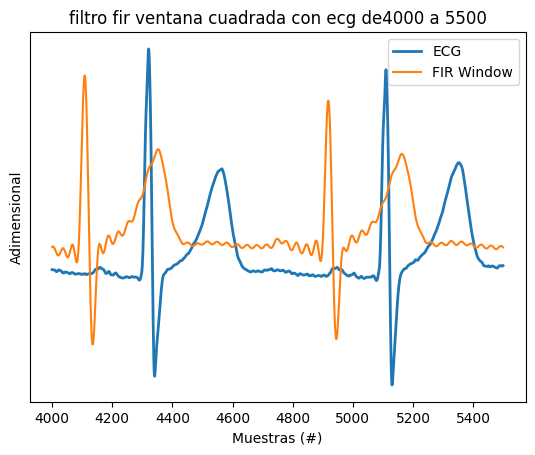

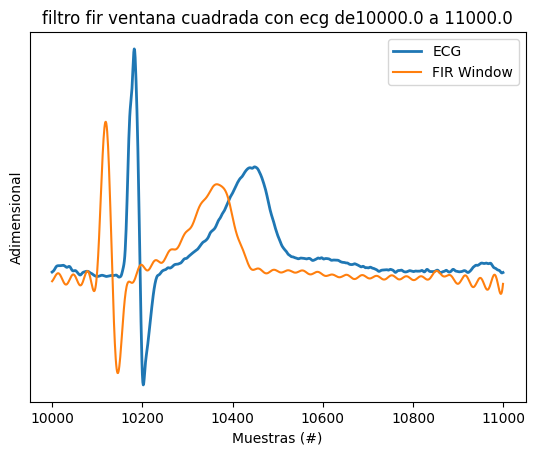

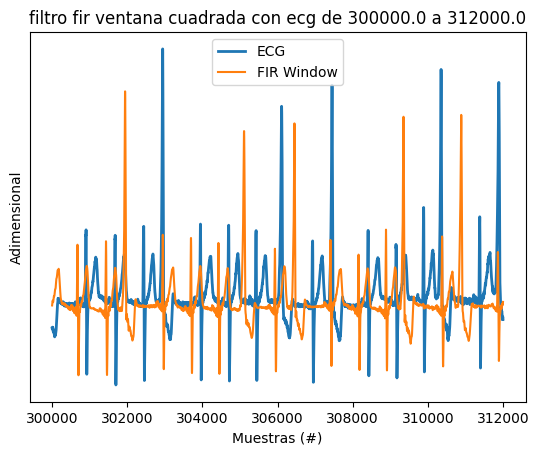

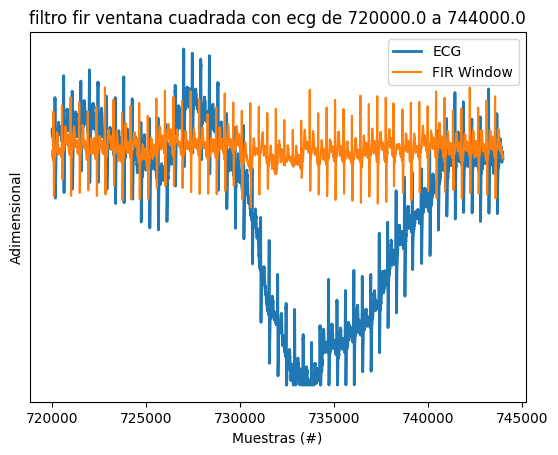

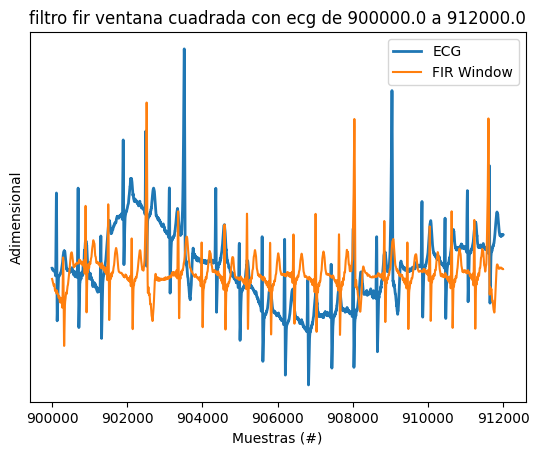

In [9]:
###################################
# Regiones de interésn sin ruido #
###################################

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('filtro fir ventana cuadrada con ecg de' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
# Regiones de interés con ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('filtro fir ventana cuadrada con ecg de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

## analisis y discusion
como se ve para el caso de los filtros IIR tanto para el cual aproxima con maxima planicidad (butterworth), como el que aproxmia con cauer, cumplen con la plantilla definidad por el ancho de banda de la ECG sin ruido es decir de 0 a 30Hz, pero la fase y retardo de grupo de ambos filtros no se asemeja nada a una funcion lineal para el caso de la fase y ni en una funcion contatante para el retardo de grupo. esto genera que la ECG filtrada en ambos casos una distorcion de fase tan grande que hace imposible el estudio de la ECG a razon de que si bien la frecuencias altas son filtradas la baja estan muy distorcionadas.

en cambio para los filtros fir no solo que cumplen la plantilla definida si no que tambien al tener una fase lineal, hace que la ECG filtrada pueda ser estudiada con mucho mayor facilidad, a cambio de esto solo se debe pagar el retardo de toda la señal filtrada causa de tener un retardo de grupo constante, el cual a la hora de estudiar la ECG filtrada como tal no tiene tanta relevancia, y tambien se debe pagar con costo computacional.

## conclusion
en conclucion los filtros IRR con apoximacion via modulos de brickwall tienden a tener una fase muy distorcionada para poder decir que el rendimiento de los filtros no es muy bueno en terminos de comprecion de la señal,igualmente esto se puede solucionar a partir de pasar el fitro nuevamente pero esta vez con la señal invertida en tiempo.

mientras que los filtros IRR presentan distorcion de fase y hace imposile el analisis de la ECG, los filtros FIR al tener una fase lineal no presentan distorcion de fase, pero si un retardo de grupo constante como se ven en los graficos los cuales estan atrasados con respecto de la señal, lo cual hace mas viable el elegir un filtro FIR que uno IRR , pq no solo cumplen con la plantilla si no que tambien tiene una distorcion de fase nula.